# Functional priors via NumPyro
An attempt at taking the core concept of functional priors from the paper *"All You Need is a Good Functional Prior for Bayesian Deep Learning"* and forked implementation, and implementing it with existing tools in NumPyro.

This attempts to align the concept with the PPL framework and samplers. Likely I have made some poor judgement calls on substituting methodology, but it appears it has potential to significantly improve the performance of BNNs built with NumPyro.

In [1]:
%matplotlib inline

In [2]:
import os,sys
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import copy, pickle
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir('..')

In [4]:
from optbnn.utils.normalization import zscore_normalization, zscore_unnormalization
from optbnn.utils import util
from optbnn.utils.data_generator import make_random_gap, gp_sample, plot_samples


In [5]:
from flaxbnn.numpyro_sampler import (
    NumPyroFlaxBNN, convert_SVI_prior_to_flax,
    simple_prior_to_flax
)

import jax.numpy as jnp
from jax import random
from flax import linen as nn

from tinygp import GaussianProcess
from tinygp import kernels as tgpkernels

In [6]:
OUT_DIR = "./exp/1D_synthetic/tanh_gaussian_new"
FIG_DIR = os.path.join(OUT_DIR, "figures")
util.ensure_dir(OUT_DIR)
util.ensure_dir(FIG_DIR)

# Generate data

In [7]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)

# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

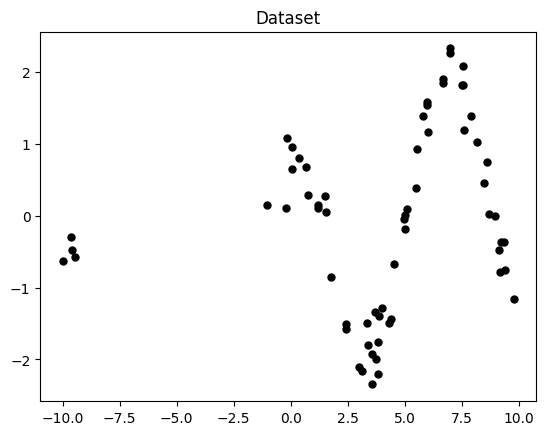

In [8]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

# Initialize priors, GP and BNN specs

In [9]:
# GP hyper-parameters
sn2 = 1e-4   # noise variance
leng = 0.6  # lengthscale
ampl = 1.0  # amplitude

kernel = tgpkernels.ExpSquared(scale=0.6) # i.e., RBF
gpprior = GaussianProcess(kernel,jnp.array(Xtest_).squeeze(), diag=sn2)

gp = GaussianProcess(kernel,jnp.array(X_).squeeze(), diag=sn2)
_, gpcond = gp.condition(jnp.array(y_).squeeze(), jnp.array(Xtest_).squeeze())

In [10]:
# Initialize BNN Priors
width = 50              # Number of units in each hidden layer
depth = 3               # Number of hidden layers
transfer_fn = "tanh"    # Activation function

# Optimize Prior

Here we use NumPyro's SVI functionality to optimise the gaussian prior for each set of weights and biases. We setup a model and guide (which specifies the params to be optimised - in our case the mu and scale for the priors) then run ELBO based SVI (with an RMSProp optimiser).

In [11]:
# Load the optimize prior
mapper_num_iters = 5000
input_dim=1
num_chains = 10
step_size = 0.01

#create hidden layer widths
width_array = [input_dim]+[width]*depth+[1]

# get model to optimise
prior_bnn = NumPyroFlaxBNN(width, depth, nn.tanh)
# define the model and guide needed for SVI
prior_bnn.define_numpyro_pretrain_model()
prior_bnn.define_guide()
# here we optimise the prior to the GP using the ELBO that falls out from our NumPyro model
prior_bnn.train_prior_model(
    random.PRNGKey(2101),Xtest_,gpprior,mapper_num_iters,num_chains,step_size=step_size
)

100%|██████████| 5000/5000 [00:31<00:00, 157.89it/s, init loss: 128381.5859, avg. loss [4751-5000]: 673.9937]   


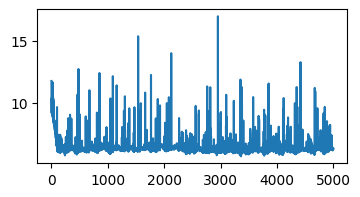

In [12]:
plt.figure(figsize=(4,2))
plt.plot(jnp.log(prior_bnn.losses))
plt.show()

In [13]:
state_dict = copy.deepcopy(prior_bnn.params)
state_dict = {k.replace('kernel_std','W_std').replace('bias_std','b_std'): float(v.item()) for k, v in state_dict.items() if 'kernel_std' in k or 'bias_std' in k}
# save to pkl state dict
display(state_dict)
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.pkl".format(mapper_num_iters))
# pickle dump the dict to ckpt path
with open(ckpt_path, 'wb') as f:
    pickle.dump(state_dict, f)
    print('Saved to {}'.format(ckpt_path))

{'Dense_0.b_std': 0.45315560698509216,
 'Dense_0.W_std': 0.5549717545509338,
 'Dense_1.b_std': 0.5436659455299377,
 'Dense_1.W_std': 7.105987548828125,
 'Dense_2.b_std': 0.5548356771469116,
 'Dense_2.W_std': 7.0543928146362305,
 'Dense_3.b_std': -1.6268510818481445,
 'Dense_3.W_std': 0.6598422527313232}

Saved to ./exp/1D_synthetic/tanh_gaussian_new/ckpts/it-5000.pkl


# Visualize Prior
Now we need to visualise the priors:

- The GP model
- The standard BNN - N(0,1)
- The optimised BNN with functional priors via the GP pretraining step

In [14]:
# load from pkl state dict
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.pkl".format(mapper_num_iters))

# use these helper functions to get to a flax compatible prior
flax_prior_def = convert_SVI_prior_to_flax(ckpt_path, width_array)
std_prior_def = simple_prior_to_flax(width_array)

display(flax_prior_def)
display(std_prior_def)

{'Dense_0.bias': (0, Array(0.9451771, dtype=float32, weak_type=True)),
 'Dense_0.kernel': (0, Array(1.0086482, dtype=float32, weak_type=True)),
 'Dense_1.bias': (0, Array(1.0014805, dtype=float32, weak_type=True)),
 'Dense_1.kernel': (0, Array(1.0050544, dtype=float32, weak_type=True)),
 'Dense_2.bias': (0, Array(1.0085616, dtype=float32, weak_type=True)),
 'Dense_2.kernel': (0, Array(0.9977639, dtype=float32, weak_type=True)),
 'Dense_3.bias': (0, Array(0.17944033, dtype=float32, weak_type=True)),
 'Dense_3.kernel': (0, Array(0.15224472, dtype=float32, weak_type=True))}

{'Dense_0.kernel': (0, Array(1., dtype=float32, weak_type=True)),
 'Dense_0.bias': (0, 1),
 'Dense_1.kernel': (0, Array(0.14142136, dtype=float32, weak_type=True)),
 'Dense_1.bias': (0, 1),
 'Dense_2.kernel': (0, Array(0.14142136, dtype=float32, weak_type=True)),
 'Dense_2.bias': (0, 1),
 'Dense_3.kernel': (0, Array(0.14142136, dtype=float32, weak_type=True)),
 'Dense_3.bias': (0, 1),
 'Dense_4.kernel': (0, Array(1., dtype=float32, weak_type=True)),
 'Dense_4.bias': (0, 1)}

### Define the BNNs

In [15]:
# get optimised model from pretraining prior
opt_bnn = NumPyroFlaxBNN(width, depth, nn.tanh)
opt_bnn.define_flax_model()
opt_bnn.define_numpyro_model(prior=flax_prior_def)

# standard N(0,1) bnn
std_bnn = NumPyroFlaxBNN(width, depth, nn.tanh)
std_bnn.define_flax_model()
std_bnn.define_numpyro_model(prior=std_prior_def)

### Plot the priors

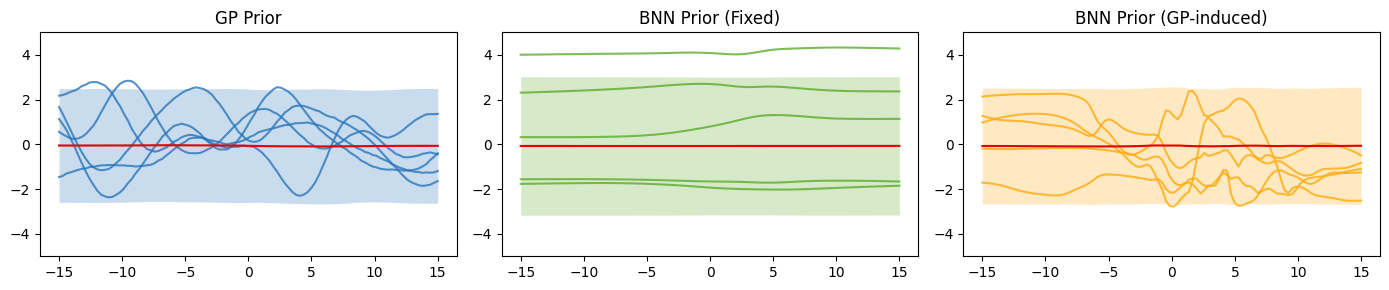

In [16]:
# Draw functions from the priors
n_plot = 4000
util.set_seed(8)
ci = 0.89
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2102)

tinygp_samples = gpprior.sample(rng_key_, (n_plot,)).T
tinygp_samples = zscore_unnormalization(tinygp_samples, y_mean, y_std)

std_bnn_samples = std_bnn.model_predict(rng_key_, Xtest_, num_samples=n_plot)
std_bnn_samples = zscore_unnormalization(std_bnn_samples, y_mean, y_std)

opt_bnn_samples = opt_bnn.model_predict(rng_key_, Xtest_, num_samples=n_plot)
opt_bnn_samples = zscore_unnormalization(opt_bnn_samples, y_mean, y_std)

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
plot_samples(Xtest, tinygp_samples, ax=axs[0], n_keep=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-5, 5])

plot_samples(Xtest, std_bnn_samples, ax=axs[1], color='xkcd:grass', n_keep=5)
axs[1].set_title('BNN Prior (Fixed)')
axs[1].set_ylim([-5, 5])

plot_samples(Xtest, opt_bnn_samples, ax=axs[2], color='xkcd:yellowish orange', n_keep=5)
axs[2].set_title('BNN Prior (GP-induced)')
axs[2].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

# Posterior Inference
Now we can use NumPyro's NUTS sampler to sample from the posterior of the BNNs. Again we compare naive priors to functional priors.

In [17]:
num_chains = 4
num_samples = 1000
num_warmup = 1000
max_tree_depth = 8

## BNN with Optimized Prior



In [18]:
opt_bnn.train_model(
    rng_key_,X_,y_,
    num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains, max_tree=max_tree_depth
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
# Make predictions
bnn_optim_preds = opt_bnn.model_predict(rng_key_, Xtest_, num_samples=n_plot, prior=False)
bnn_optim_preds = zscore_unnormalization(bnn_optim_preds, y_mean, y_std)

## BNN with Fixed Prior


In [20]:
std_bnn.train_model(
    rng_key_,X_,y_,
    num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains, max_tree=max_tree_depth
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
# Make predictions
bnn_std_preds = std_bnn.model_predict(rng_key_, Xtest_, num_samples=n_plot, prior=False)
bnn_std_preds = zscore_unnormalization(bnn_std_preds, y_mean, y_std)

## Visualize Predictive Posterior

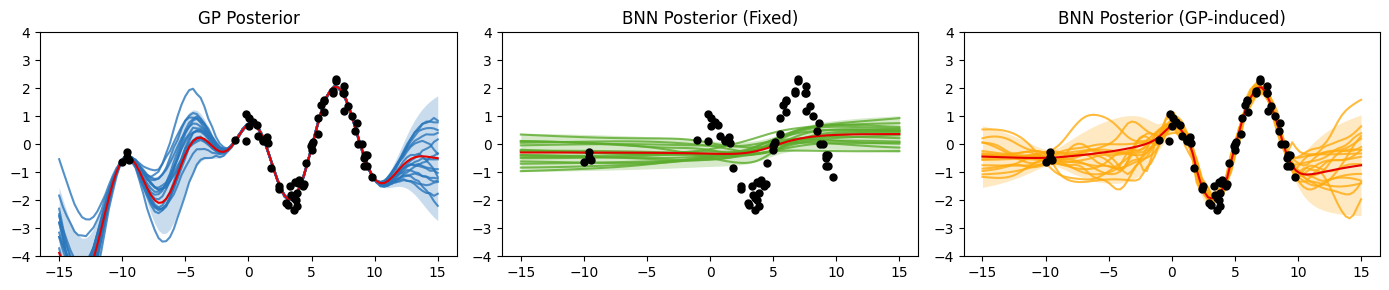

In [22]:
util.set_seed(8)
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

gp_preds = gpcond.sample(rng_key_, (n_plot,)).T
gp_preds = zscore_unnormalization(gp_preds, y_mean, y_std)
plot_samples(Xtest, gp_preds, ax=axs[0], n_keep=16)
axs[0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0].set_title('GP Posterior')
axs[0].set_ylim([-4, 4])

plot_samples(Xtest, bnn_std_preds, ax=axs[1], color='xkcd:grass', n_keep=16)
axs[1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1].set_title('BNN Posterior (Fixed)')
axs[1].set_ylim([-4, 4])

plot_samples(Xtest, bnn_optim_preds, ax=axs[2], color='xkcd:yellowish orange', n_keep=16)
axs[2].plot(X, y, 'ok', zorder=10, ms=5)
axs[2].set_title('BNN Posterior (GP-induced)')
axs[2].set_ylim([-4, 4])

plt.tight_layout()
plt.show()